In [154]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib

In [155]:
# Load the dataset
data = pd.read_csv('alzheimers_disease_data.csv')

# Display the first 5 rows of the dataset
data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [156]:
# Show the info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

In [157]:
# Eliminar columnas innecesarias
data = data.drop(['PatientID', 'DoctorInCharge'], axis=1)

# Separar características y variable objetivo
x = data.drop("Diagnosis", axis=1)
y = data["Diagnosis"]

In [158]:
# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

In [159]:
# Definir el pipeline para la selección de características y el modelo
pipeline = Pipeline([
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42))
])

In [160]:
param_grid = {
    'selector__k': [10, 15, 20],  # Probar distintos números de características
    'classifier__n_estimators': [200, 300, 500],  # Más árboles para estabilidad
    'classifier__max_depth': [10, 15, 20],  # Limitar profundidad para evitar sobreajuste
    'classifier__min_samples_split': [5, 10],  # Evitar divisiones demasiado específicas
    'classifier__min_samples_leaf': [2, 4],  # Evitar hojas con muy pocos datos
    'classifier__class_weight': [None, 'balanced']  # Ajustar peso de clases
}

In [161]:
# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__max_depth': [10, 15, 20],
                         'classifier__min_samples_leaf': [2, 4],
                         'classifier__min_samples_split': [5, 10],
                         'classifier__n_estimators': [200, 300, 500],
                         'selector__k': [10, 15, 20]},
             scoring='accuracy')

In [162]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

In [163]:
# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(x_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       277
           1       0.97      0.92      0.94       153

    accuracy                           0.96       430
   macro avg       0.96      0.95      0.95       430
weighted avg       0.96      0.96      0.96       430

Confusion Matrix:
[[272   5]
 [ 13 140]]


In [164]:
# Mostrar los mejores hiperparámetros
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 500, 'selector__k': 10}


In [165]:
# Mostrar las características seleccionadas
selected_features = x.columns[best_model.named_steps['selector'].get_support()]
print(f"Selected Features: {selected_features}")

Selected Features: Index(['EducationLevel', 'SleepQuality', 'SystolicBP', 'DiastolicBP',
       'CholesterolHDL', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints',
       'BehavioralProblems', 'ADL'],
      dtype='object')


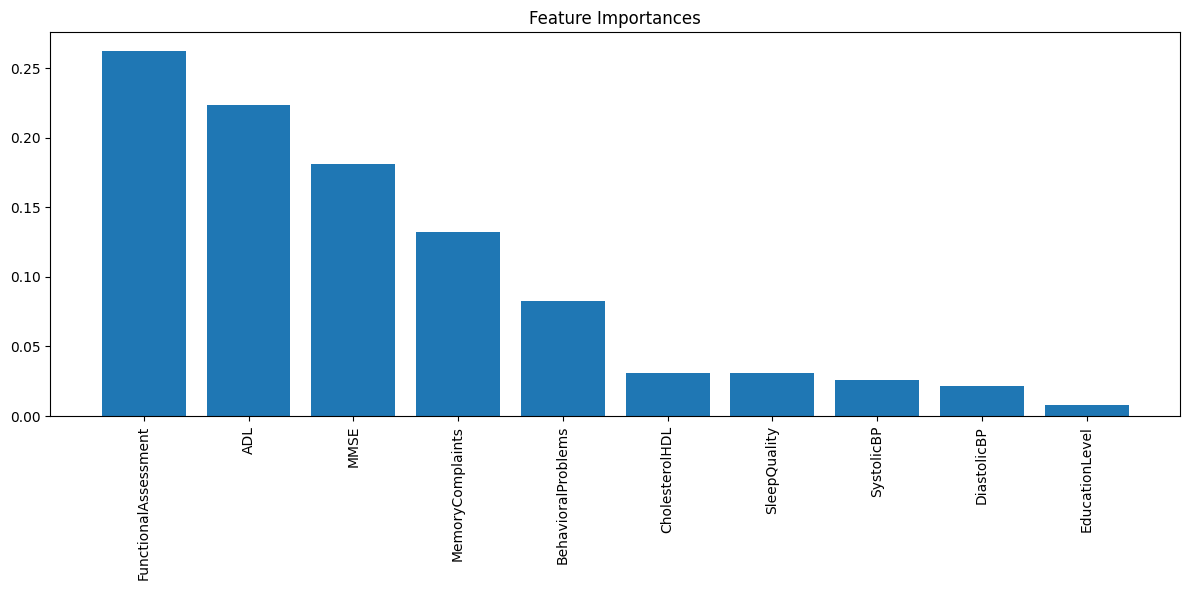

In [166]:
# Mostrar la importancia de las variables
importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), selected_features[indices], rotation=90)
plt.tight_layout()
plt.show()

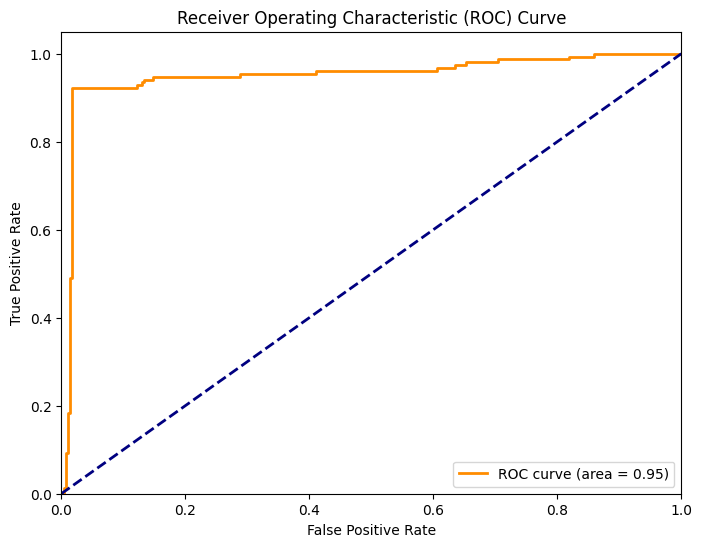

In [167]:
from sklearn.metrics import roc_curve, auc

# Mostrar la curva ROC
y_pred_proba = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [168]:
# Realizar validación cruzada
cv_scores = cross_val_score(best_model, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Accuracy Scores: [0.99069767 0.98372093 0.98372093 0.99534884 0.81585082]
Mean Cross-Validation Accuracy: 0.95


In [169]:
# Probar el modelo con nuevos datos
new_data = pd.DataFrame({
    'Age': [70, 65, 80, 75, 68, 72, 60, 78, 66, 74],
    'Gender': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'Ethnicity': [1, 2, 3, 0, 1, 2, 3, 0, 1, 2],
    'EducationLevel': [2, 3, 1, 2, 3, 2, 1, 3, 2, 1],
    'BMI': [25.0, 27.5, 22.0, 30.0, 26.0, 28.0, 24.0, 29.0, 23.0, 27.0],
    'Smoking': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'AlcoholConsumption': [5.0, 10.0, 2.0, 8.0, 6.0, 7.0, 3.0, 9.0, 4.0, 11.0],
    'PhysicalActivity': [3.0, 5.0, 2.0, 4.0, 3.0, 6.0, 1.0, 5.0, 2.0, 4.0],
    'DietQuality': [6.0, 7.0, 5.0, 8.0, 6.0, 7.0, 5.0, 8.0, 6.0, 7.0],
    'SleepQuality': [7.0, 6.0, 8.0, 5.0, 7.0, 6.0, 8.0, 5.0, 7.0, 6.0],
    'FamilyHistoryAlzheimers': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    'CardiovascularDisease': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'Diabetes': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'Depression': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'HeadInjury': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'Hypertension': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    'SystolicBP': [120, 130, 110, 140, 125, 135, 115, 145, 120, 130],
    'DiastolicBP': [80, 85, 75, 90, 82, 88, 78, 92, 80, 85],
    'CholesterolTotal': [200, 220, 190, 230, 210, 225, 195, 235, 205, 215],
    'CholesterolLDL': [100, 110, 90, 120, 105, 115, 95, 125, 100, 110],
    'CholesterolHDL': [50, 55, 45, 60, 52, 57, 47, 62, 50, 55],
    'CholesterolTriglycerides': [150, 160, 140, 170, 155, 165, 145, 175, 150, 160],
    'MMSE': [18, 20, 16, 19, 17, 21, 15, 22, 18, 20],
    'FunctionalAssessment': [5, 6, 4, 7, 5, 6, 4, 7, 5, 6],
    'MemoryComplaints': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    'BehavioralProblems': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'ADL': [6, 7, 5, 8, 6, 7, 5, 8, 6, 7],
    'Confusion': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'Disorientation': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'PersonalityChanges': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'DifficultyCompletingTasks': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    'Forgetfulness': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
})

In [170]:
# Seleccionar las características principales
new_data_selected = best_model.named_steps['selector'].transform(new_data)

In [171]:
# Hacer la predicción
new_predictions = best_model.named_steps['classifier'].predict(new_data_selected)
new_predictions_proba = best_model.named_steps['classifier'].predict_proba(new_data_selected)

In [172]:
# Mostrar las predicciones para los nuevos datos
print("New Data Predictions:")
for i, pred in enumerate(new_predictions):
    print(f"Data {i+1}: Prediction: {'Positive' if pred == 1 else 'Negative'}, Probability: {new_predictions_proba[i][1]*100:.2f}%")

New Data Predictions:
Data 1: Prediction: Positive, Probability: 65.23%
Data 2: Prediction: Negative, Probability: 16.01%
Data 3: Prediction: Positive, Probability: 88.11%
Data 4: Prediction: Negative, Probability: 13.69%
Data 5: Prediction: Positive, Probability: 65.54%
Data 6: Prediction: Negative, Probability: 13.31%
Data 7: Prediction: Positive, Probability: 90.03%
Data 8: Prediction: Negative, Probability: 15.57%
Data 9: Prediction: Positive, Probability: 65.23%
Data 10: Prediction: Negative, Probability: 13.19%


In [173]:
# Revisar la distribución de clases en el conjunto de datos
print("Class Distribution in the Dataset:")
print(data['Diagnosis'].value_counts())

Class Distribution in the Dataset:
Diagnosis
0    1389
1     760
Name: count, dtype: int64


In [174]:
# Guardar el modelo y el selector de características
joblib.dump(best_model, 'best_random_forest_model.pkl')
joblib.dump(best_model.named_steps['selector'], 'feature_selector.pkl')

['feature_selector.pkl']